In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
bempp.api.enable_console_logging()

<StreamHandler stderr (DEBUG)>

In [2]:
grid = bempp.api.shapes.regular_sphere(3)
print(f"Number of elements: {grid.number_of_elements}")

Number of elements: 512


In [24]:
wavenumber = 3

In [25]:
rwg = bempp.api.function_space(grid,'RWG',0)
snc = bempp.api.function_space(grid,'SNC',0)

In [26]:
mat = bempp.api.operators.boundary.maxwell.electric_field(rwg, rwg, snc, wavenumber).weak_form().A

root:INFO: Regular kernel vector length: 8 (double precision)
root:INFO: Regular kernel runtime [ms]: 31.820390999999997
root:INFO: Singular kernel runtime [ms]: 74.898366


In [27]:
mat.shape

(768, 768)

In [28]:
from bempp.api.utils import Octree

vertices = np.empty((3,rwg.global_dof_count),np.float64)
for index in range(rwg.global_dof_count):
    elem,local_id = rwg.global2local[index][0]
    edge_id = grid.element_edges[local_id,elem]
    vertices[:,index] = .5*(grid.vertices[:,grid.edges[0,edge_id]] + grid.vertices[:,grid.edges[0,edge_id]])
    
box = grid.bounding_box
tree = Octree(box[:,0],box[:,1],2,vertices)

In [29]:
sorted_indices = tree.sorted_indices

In [30]:
sorted_mat = mat[:, sorted_indices][sorted_indices, :]
#sorted_mat[0:n//2,n//2:] = np.zeros((n//2,n//2))
#sorted_mat[n//2:,0:n//2] = np.zeros((n//2,n//2))

In [31]:
n = sorted_mat.shape[0]
nboxes = 12
size = n // nboxes

In [11]:
def get_box(nx, ny, sorted_mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return sorted_mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [12]:
def plot_box_ranks(sorted_mat, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, sorted_mat, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

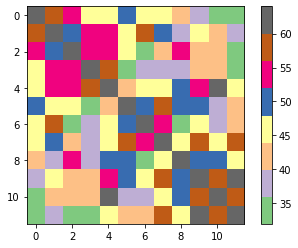

In [32]:
plot_box_ranks(sorted_mat,nboxes,n)

In [33]:
def plot_singular_values(nx, ny, sorted_mat, nboxes, n):
    """Plot singular values of a given box."""
    from scipy.linalg import svdvals
    s = svdvals(get_box(nx, ny, sorted_mat, nboxes, n))
    plt.semilogy(s)
    plt.xlabel('k')
    plt.ylabel('sigma_k')

In [35]:
Eigs,evals = np.linalg.eig(sorted_mat)

Text(0.5, 1.0, 'EFIE_weak')

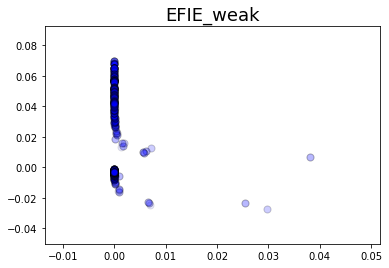

In [42]:
plt.scatter(np.real(Eigs),np.imag(Eigs),color='b', s=50, alpha=.1, edgecolors='black')
plt.title('EFIE_weak', fontsize = 18)

In [14]:
def get_con_box(i,sorted_mat,nboxes,n):
    BB = sorted_mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(sorted_mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [15]:
def L(i,k,sorted_mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,sorted_mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,sorted_mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [16]:
def index_set(k,sorted_mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,sorted_mat,nboxes,n)[1][0:k])
    return l

In [17]:
def S(k,sorted_mat,nboxes,n):
    ll = index_set(k,sorted_mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,sorted_mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [18]:
def R(i,k,sorted_mat,nboxes,n):
    RR = np.transpose(L(i,k,sorted_mat,nboxes,n)[0])
    return RR

In [19]:
def new_S(k,sorted_mat,nboxes,n):
    mat_ = S(k,sorted_mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,sorted_mat,nboxes,n) @ np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @ L(i,k,sorted_mat,nboxes,n)[0])
    return mat_

In [20]:
def logdet_method2(k,sorted_mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,sorted_mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,sorted_mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,sorted_mat,nboxes,n)@np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @L(i,k,sorted_mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [21]:
def time_logdet(k,sorted_mat,nboxes,n):
    start_time = time.time()
    a = logdet_method2(k,sorted_mat,nboxes,n)
    end_time = time.time()
    b = end_time - start_time
    return b

#### Level 4 time

In [22]:
l_time4 = []
for i in range(1,size+1):
    l_time4.append(time_logdet(i,sorted_mat,nboxes,n))

#### Level 3 time

In [38]:
l_time3 = []
for i in range(1,size+1):
    l_time3.append(time_logdet(i,sorted_mat,nboxes,n))

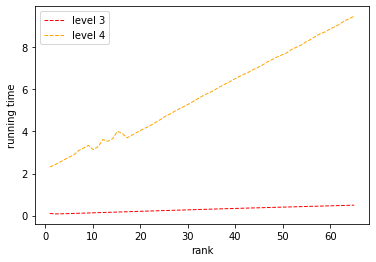

In [40]:
k_rank = np.linspace(1,size+1,size)
plt.plot(k_rank, l_time3, color='red',linewidth=1.0,linestyle='--')
plt.plot(k_rank, l_time4, color='orange',linewidth=1.0,linestyle='--')
plt.xlabel('rank')
plt.ylabel('running time')
plt.legend(['level 3','level 4'])
plt.show()

#### Level 3 exact value

In [41]:
P3,L3,U3 = scipy.linalg.lu(sorted_mat)

logdet3 = 0
for i in range(n):
    logdet3 += math.log(abs(U3[i,i]))
print (logdet3)

-3020.5547228506607


#### Level 3 approximated value

In [42]:
l3_det = []
for i in range(1,size+1):
    l3_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### relative error of computing $\log\det(A)$ in level 3

In [43]:
relative_error_3 = []
for i in range(size):
    relative_error_3.append(np.log10(abs((l3_det[i]-logdet3)/logdet3)))

#### Level 4 exact value

In [24]:
P4,L4,U4 = scipy.linalg.lu(sorted_mat)

logdet4 = 0
for i in range(n):
    logdet4 += math.log(abs(U4[i,i]))
print (logdet4)

-15623.640071487347


#### Level 4 approximated value

In [25]:
l4_det = []
for i in range(1,size+1):
    l4_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### relative error of computing $\log\det(A)$ in level 4

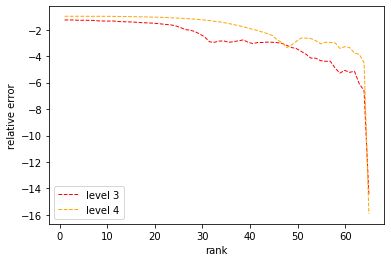

In [46]:
relative_error_4 = []
for i in range(size):
    relative_error_4.append(np.log10(abs((l4_det[i]-logdet4)/logdet4)))
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,relative_error_3, color = 'red', linewidth = 1.0, linestyle = '--')
plt.plot(k_det,relative_error_4, color = 'orange', linewidth = 1.0, linestyle = '--')
plt.xlabel('rank')
plt.ylabel('relative error')
plt.legend(['level 3','level 4'])
plt.show()

#### Level 4 exact value of $A_{\infty}$

In [124]:
PP4,LL4,UU4 = scipy.linalg.lu(sorted_mat)

logdet44 = 0
for i in range(n):
    logdet44 += math.log(abs(UU4[i,i]))

In [133]:
logdet4 - logdet44

-183.61418038781449

#### Level 3 exact value of $A_{\infty}$

In [105]:
PP3,LL3,UU3 = scipy.linalg.lu(sorted_mat)

logdet33 = 0
for i in range(n):
    logdet33 += math.log(abs(UU3[i,i]))

In [106]:
logdet3-logdet33

-39.57114200099977

#### Level 3 approximated value of $A_{\infty}$

In [103]:
l33_det = []
for i in range(1,size+1):
    l33_det.append(logdet_method2(i,sorted_mat,nboxes,n))

KeyboardInterrupt: 

#### Exact difference

In [109]:
logdet_exact_diff = []
for i in range(size):
    logdet_exact_diff.append((logdet3-logdet33).real)

#### relative error of $\log\det(A)-\log\det(A_{\infty})$

In [103]:
relative_error3 = []
for i in range(size):
    a = abs((l3_det[i] - l33_det[i])/(logdet3-logdet33).real)
    relative_error3.append(np.log10(a))

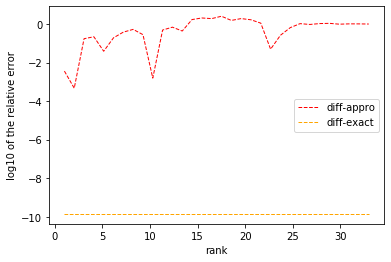

In [111]:
k_det = np.linspace(1,size+1,size)


plt.plot(k_det,relative_error3,color='red',linewidth=1.0,linestyle='--')
plt.plot(k_det,logdet_exact_diff,color='orange',linewidth=1.0,linestyle='--')


plt.legend(['diff-appro','diff-exact'])

plt.ylabel('log10 of the relative error')
plt.xlabel('rank')
plt.show()